# Probabilistic PCA (PPCA) vs Classical PCA on MNIST

This notebook downloads the MNIST dataset (if not already present), performs dimensionality reduction with:

- Deterministic PCA (via SVD)
- Probabilistic PCA (EM algorithm)

Then it compares reconstruction quality (MSE & PSNR) across several latent dimensions and visualizes sample reconstructions.

Implementation avoids external ML libraries (no scikit-learn / PyTorch) and relies on NumPy + SciPy only.


In [ ]:
import os, gzip, math, urllib.request, pathlib, io
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

DATA_DIR = pathlib.Path('dataset')
DATA_DIR.mkdir(exist_ok=True)

MNIST_URLS = {
    'train_images': 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'train_labels': 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
    'test_images': 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    'test_labels': 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
}
TF_MNIST_NPZ = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

def download_mnist():
    for name, url in MNIST_URLS.items():
        out_path = DATA_DIR / f'{name}.gz'
        if not out_path.exists():
            print(f'Downloading {name} from Yann site...')
            urllib.request.urlretrieve(url, out_path)

# Parsing IDX format

def _read_idx(filename, expected_magic):
    with gzip.open(filename, 'rb') as f:
        import struct
        magic = struct.unpack('>I', f.read(4))[0]
        if magic != expected_magic:
            raise ValueError(f'Bad magic {magic} for {filename}, expected {expected_magic}')
        if expected_magic == 2051:  # images
            n_images = struct.unpack('>I', f.read(4))[0]
            n_rows = struct.unpack('>I', f.read(4))[0]
            n_cols = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape(n_images, n_rows*n_cols)
            return data.astype(np.float32) / 255.0
        elif expected_magic == 2049:  # labels
            n_items = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
            return data
        else:
            raise ValueError('Unsupported magic')

def load_mnist():
    try:
        download_mnist()
        X_train = _read_idx(DATA_DIR/'train_images.gz', 2051)
        y_train = _read_idx(DATA_DIR/'train_labels.gz', 2049)
        X_test = _read_idx(DATA_DIR/'test_images.gz', 2051)
        y_test = _read_idx(DATA_DIR/'test_labels.gz', 2049)
        return (X_train, y_train), (X_test, y_test)
    except Exception as e:
        print('Raw MNIST download failed, falling back to TensorFlow mirror:', e)
        npz_path = DATA_DIR / 'mnist_tf_mirror.npz'
        if not npz_path.exists():
            print('Downloading mnist.npz mirror...')
            urllib.request.urlretrieve(TF_MNIST_NPZ, npz_path)
        with np.load(npz_path) as data:
            X_train = data['x_train'].reshape(-1, 28*28).astype(np.float32)/255.0
            y_train = data['y_train']
            X_test = data['x_test'].reshape(-1, 28*28).astype(np.float32)/255.0
            y_test = data['y_test']
        return (X_train, y_train), (X_test, y_test)

# Classical PCA using SVD

def pca_fit(X, k):
    mu = X.mean(axis=0)
    Xc = X - mu
    U, S, Vt = svd(Xc, full_matrices=False)
    W = Vt[:k].T
    Z = Xc @ W
    return {'mu': mu, 'W': W, 'Z': Z, 'S': S[:k], 'Vt': Vt}

def pca_reconstruct(model, Z=None):
    if Z is None:
        Z = model['Z']
    return Z @ model['W'].T + model['mu']

# Probabilistic PCA

def ppca_em(X, k, max_iter=100, tol=1e-5, verbose=False, seed=0):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    mu = X.mean(axis=0)
    Xc = X - mu
    W = rng.normal(scale=0.01, size=(d, k))
    sigma2 = 1.0
    I_k = np.eye(k)
    for it in range(max_iter):
        M = W.T @ W + sigma2 * I_k
        M_inv = np.linalg.inv(M)
        Ez = Xc @ W @ M_inv
        Ezz = sigma2 * M_inv + Ez[:, :, None] * Ez[:, None, :]
        Sx = Xc.T @ Ez
        sum_Ezz = Ezz.sum(axis=0)
        W_new = Sx @ np.linalg.inv(sum_Ezz)
        recon = Ez @ W_new.T
        diff = Xc - recon
        sigma2_new = np.sum(diff**2) / (n * d)
        if np.linalg.norm(W_new - W) / (np.linalg.norm(W) + 1e-12) < tol and abs(sigma2_new - sigma2) / (sigma2 + 1e-12) < tol:
            W = W_new; sigma2 = sigma2_new
            break
        W = W_new
        sigma2 = sigma2_new
    return {'mu': mu, 'W': W, 'sigma2': sigma2}

def ppca_transform(model, X):
    mu, W, sigma2 = model['mu'], model['W'], model['sigma2']
    Xc = X - mu
    M = W.T @ W + sigma2 * np.eye(W.shape[1])
    return Xc @ W @ np.linalg.inv(M)

def ppca_reconstruct(model, X):
    Z = ppca_transform(model, X)
    return Z @ model['W'].T + model['mu']


In [2]:
# Load data (use a subset for speed during development)
from pathlib import Path
npz_path = Path('data_mnist/mnist_tf_mirror.npz')
if not npz_path.exists():
    print('Downloading mnist.npz mirror...')
    import urllib.request
    urllib.request.urlretrieve('https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz', npz_path)
with np.load(npz_path) as data:
    X_train = data['x_train'].reshape(-1, 28*28).astype(np.float32)/255.0
    y_train = data['y_train']
    X_test = data['x_test'].reshape(-1, 28*28).astype(np.float32)/255.0
    y_test = data['y_test']

train_subset = 10000
test_subset = 2000
Xtr = X_train[:train_subset]
Xte = X_test[:test_subset]
print('Data shapes:', Xtr.shape, Xte.shape)


Data shapes: (10000, 784) (2000, 784)


In [3]:
def mse(a,b):
    return np.mean((a-b)**2)

def psnr(a,b):
    m = mse(a,b)
    if m==0: return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(m))

latent_dims = [2,5,10,20,40,60]
results = []
for k in latent_dims:
    print(f'k={k}')
    pca_m = pca_fit(Xtr, k)
    Xrec_pca = pca_reconstruct(pca_m, (Xte - pca_m['mu']) @ pca_m['W'])  # ensure using test projection
    ppca_m = ppca_em(Xtr, k, max_iter=200, tol=1e-4)
    Xrec_ppca = ppca_reconstruct(ppca_m, Xte)
    m_pca = mse(Xte, Xrec_pca)
    m_ppca = mse(Xte, Xrec_ppca)
    results.append({'k':k,'PCA_MSE':m_pca,'PPCA_MSE':m_ppca,'PCA_PSNR':psnr(Xte,Xrec_pca),'PPCA_PSNR':psnr(Xte,Xrec_ppca)})

import pandas as pd
import json
print(pd.DataFrame(results))


k=2
k=5
k=10
k=20
k=40
k=60
    k   PCA_MSE  PPCA_MSE   PCA_PSNR  PPCA_PSNR
0   2  0.054254  0.054256  12.655668  12.655543
1   5  0.044166  0.044169  13.549160  13.548816
2  10  0.034385  0.034391  14.636313  14.635504
3  20  0.024299  0.024311  16.144134  16.142004
4  40  0.014641  0.014660  18.344300  18.338531
5  60  0.010074  0.010099  19.967861  19.957429


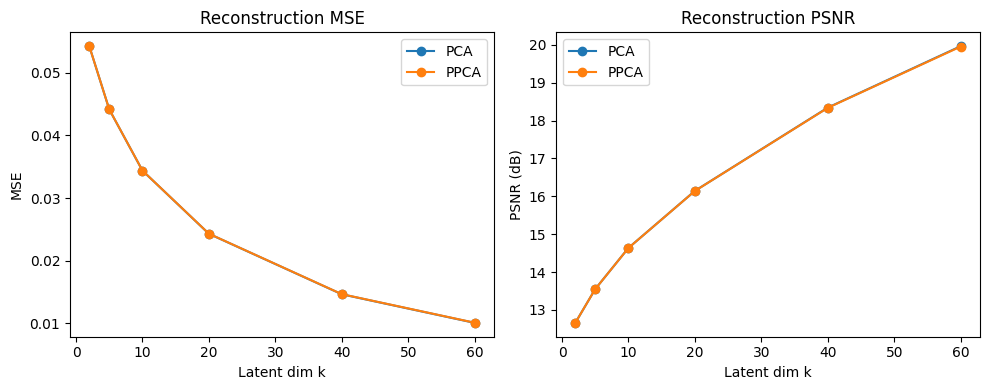

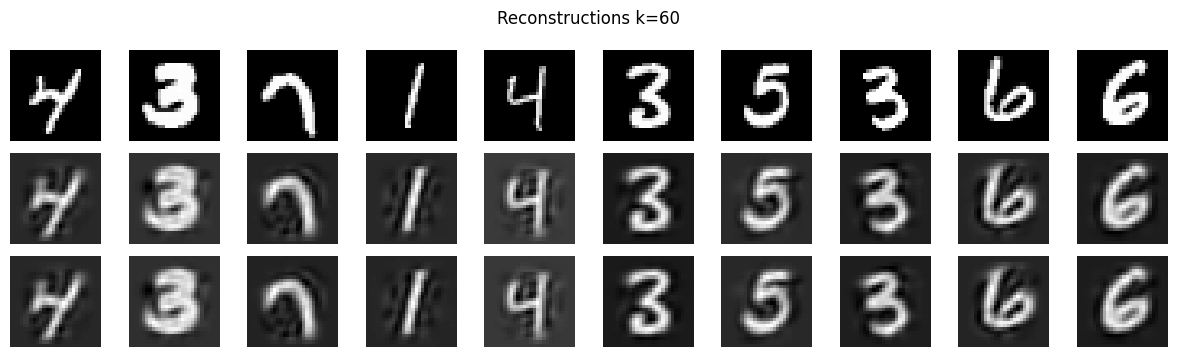

In [4]:
# Visualize metrics
import pandas as pd
import numpy as np

_df = pd.DataFrame(results)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(_df['k'], _df['PCA_MSE'], 'o-', label='PCA')
plt.plot(_df['k'], _df['PPCA_MSE'], 'o-', label='PPCA')
plt.xlabel('Latent dim k'); plt.ylabel('MSE'); plt.title('Reconstruction MSE'); plt.legend()
plt.subplot(1,2,2)
plt.plot(_df['k'], _df['PCA_PSNR'], 'o-', label='PCA')
plt.plot(_df['k'], _df['PPCA_PSNR'], 'o-', label='PPCA')
plt.xlabel('Latent dim k'); plt.ylabel('PSNR (dB)'); plt.title('Reconstruction PSNR'); plt.legend()
plt.tight_layout()
plt.show()

# Show sample reconstructions for last k
k_last = latent_dims[-1]
# recompute models to grab reconstructions
pca_m_last = pca_fit(Xtr, k_last)
Xrec_pca_last = pca_reconstruct(pca_m_last, (Xte - pca_m_last['mu']) @ pca_m_last['W'])
ppca_m_last = ppca_em(Xtr, k_last, max_iter=200, tol=1e-4)
Xrec_ppca_last = ppca_reconstruct(ppca_m_last, Xte)

n_show = 10
idx = np.random.choice(len(Xte), n_show, replace=False)
fig, axes = plt.subplots(3, n_show, figsize=(1.2*n_show, 3.6))
for i,j in enumerate(idx):
    axes[0,i].imshow(Xte[j].reshape(28,28), cmap='gray'); axes[0,i].axis('off')
    axes[1,i].imshow(Xrec_pca_last[j].reshape(28,28), cmap='gray'); axes[1,i].axis('off')
    axes[2,i].imshow(Xrec_ppca_last[j].reshape(28,28), cmap='gray'); axes[2,i].axis('off')
axes[0,0].set_ylabel('Original')
axes[1,0].set_ylabel('PCA')
axes[2,0].set_ylabel('PPCA')
plt.suptitle(f'Reconstructions k={k_last}')
plt.tight_layout()
plt.show()
